In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
import sys, os

from Bio import SeqIO
import Bio.PDB, warnings
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
from Bio import pairwise2

pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [30]:
data_path = Path('/home', 'eclay','Pfam-A.full')
data_path = Path('Pfam-A.full')
DCA_ER_dir = Path('/home/evan/PycharmProjects/DCA_ER/')



pfam_id = 'PF00023'
pfam_id = 'PF00011'
pfam_id = 'PF14525'
pfam_id = 'PF03496'
pfam_id = 'PF00186'
pfam_id = 'PF03678'


n_jobs = 6
create_new = False
removing_cols = False


DCA_ER_dir = '/data/cresswellclayec/DCA_ER/'
msa_npy_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
msa_fa_file  = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
pdb_ref_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id
out_dir = '%sprotein_data/di/' % DCA_ER_dir

# Define data directories
# Need to think on best way to do this..
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_ER_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
print(pdb_df.head())


number of pdb structures: 24
        PF seq            id uniprot_start uniprot_end pdb_id chain pdb_start  \
0  PF03678  12   CAPSH_ADE02           652         874   1P2Z     A       651   
1  PF03678  25  Q8UY79_9ADEN           617         839   2OBE     A       616   
2  PF03678  25  Q8UY79_9ADEN           617         839   2OBE     C       616   
3  PF03678  25  Q8UY79_9ADEN           617         839   2OBE     B       616   
4  PF03678  50   CAPSH_ADEG1           606         846   2INY     A       605   

  pdb_end  
0     873  
1     838  
2     838  
3     838  
4     845  


In [31]:
ipdb = 0
printing = True
print('seq:',int(pdb[ipdb,1]))

start_time = timeit.default_timer()
pdb_matches= tools.find_best_pdb(pfam_id, data_path, create_new=create_new)
run_time = timeit.default_timer() - start_time

print('finding best match takes %f seconds ' % run_time)

seq: 12
Raw-Query PDB dataframe gives 90 matches... 

Sorted PDB matches (50 matches): 
     MSA Index  PDB ID  Score  Identity        E-value  Bitscore  \
0          50  2INY_1    1.0     1.000  1.029000e-168       523   
1          66  6QI5_1    1.0     1.000  4.040000e-167       518   
2          33  6YBA_1    1.0     1.000  1.308000e-153       478   
3          44  6B1T_1    1.0     1.000  1.308000e-153       478   
4          81  6B1T_1    1.0     1.000  1.308000e-153       478   
5          24  5TX1_1    1.0     0.995  3.369000e-153       477   
6          38  5TX1_1    1.0     0.995  3.369000e-153       477   
7          16  2OBE_1    1.0     1.000  6.330000e-153       476   
8          56  2OBE_1    1.0     1.000  6.330000e-153       476   
9          12  1P2Z_1    1.0     1.000  1.189000e-152       475   
10         80  5TX1_1    1.0     0.991  2.235000e-152       475   
11         58  5TX1_1    1.0     0.991  2.235000e-152       475   
12         27  5TX1_1    1.0     0.991  

In [32]:
## pfam_id = 'PF03678'

individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_ER_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])


number of pdb structures: 24


In [33]:
index_pdb = 0
pdb_select = pdb_matches.iloc[index_pdb]

# enforce old PDB refs structure for PF00186
# pdb_select = pdb_matches.loc[pdb_matches['MSA Index']==69].iloc[0]

query_seq = pdb_select['Query Aligned Seq']
subject_seq = pdb_select['Subject Aligned Seq']
mismatch_cols = [i for i,a in enumerate(query_seq) if a != subject_seq[i]]

print(query_seq)
print('Selected PDB: \n', pdb_select)

print('\n\nMismatching Columns between query and subject: ', mismatch_cols)


NATNDQTFADYLGAKNALYNVPAGSTLLTINIPARTWEGMRGWSFTRLKASETPQLGAQYDVGFKYSGSIPYSDGTFYLSHTFRSMSVLFDTSINWPGNDRLLTPNLFEIKRPVATDSEGFTMSQCDMTKDWFLVQMATNYNYVYNGYRFWPDRHYFHYDFLRNFDPMSRQGPNFLDTTLYDLVSSTPVVNDTGSQPSQDNVRNNSGFIAPRSWPVWTAQQGEAWPANWPYPLIGNDAISS
Selected PDB: 
 MSA Index                                                             50
PDB ID                                                            2INY_1
Score                                                                1.0
Identity                                                             1.0
E-value                                                              0.0
Bitscore                                                             523
Alignment Length                                                     241
Mismatches                                                             0
Gaps Opened                                                            0
Query Beg                                                              1
Query End   

In [34]:


pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()

def contact_map_new(pdb_id, pdb_range, pdb_chain, cols_removed, queried_seq, pdb_out_dir='./'):
    if printing:
        print('\n\n#-----------------------#\nGenerating Contact Map\n#----------------------------#\n')

    pdb_file = pdb_list.retrieve_pdb_file(str(pdb_id), file_format='pdb', pdir=pdb_out_dir)
    # pdb_file = pdb_list.retrieve_pdb_file(pdb_id)

    pdb_start = pdb_range[0] - 2
    pdb_end = pdb_range[1] - 1

    pdb_model = pdb_parser.get_structure(str(pdb_id), pdb_file)[0]
    found_pp_match = False
    for chain in pdb_model.get_chains():
        #print(str(pdb_chain))
        #chain = pdb_model[pdb_chain]
        ppb = PPBuilder().build_peptides(chain)

        # Get full list of CA coords from poly_seq
        poly_seq = list() 
        pp_ca_coords_full = list()
        for i, pp in enumerate(ppb):
            for char in str(pp.get_sequence()):
                poly_seq.append(char)
            poly_seq_ca_atoms = pp.get_ca_list()
            pp_ca_coords_full.extend([a.get_coord() for a in poly_seq_ca_atoms])      
            
        str_index = ''.join(poly_seq).find(queried_seq)
        if str_index == -1:
            continue
        else:
            found_pp_match = True
            # Get curated polypeptide sequence (using cols_removed) & Get coords of curated pp seq
            pdb_start = str_index
            pdb_end = str_index + len(queried_seq)
            poly_seq_range = poly_seq[pdb_start:pdb_end]
            print('Found Match!\n')
            print(''.join(poly_seq_range))
            print(queried_seq)
            break

    if not found_pp_match:
        print(''.join(poly_seq_range))
        print(len(poly_seq_range))
        print(queried_seq)
        print(len(queried_seq))
        print('ERROR: downloaded pdb sequence does not match the returned sequence from the query')
        sys.exit()
    
    poly_seq_curated = np.delete(poly_seq_range, cols_removed)
    
    n_amino_full = len(pp_ca_coords_full)

    # Extract coordinates and sequence char in PDB-range\
    pp_ca_coords_full_range = pp_ca_coords_full[pdb_start:pdb_end]
    pp_ca_coords_curated = np.delete(pp_ca_coords_full_range, cols_removed, axis=0)

    ct_full = distance_matrix(pp_ca_coords_full, pp_ca_coords_full)
    ct = distance_matrix(pp_ca_coords_curated, pp_ca_coords_curated)



    return ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range



ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range = contact_map_new(pdb_id=pdb_select['PDB ID'][:4], pdb_range=[pdb_select['Subject Beg'], pdb_select['Subject End']], \
                pdb_chain='A', cols_removed=mismatch_cols, queried_seq=subject_seq,  pdb_out_dir='./')



#-----------------------#
Generating Contact Map
#----------------------------#

Found Match!

NATNDQTFADYLGAKNALYNVPAGSTLLTINIPARTWEGMRGWSFTRLKASETPQLGAQYDVGFKYSGSIPYSDGTFYLSHTFRSMSVLFDTSINWPGNDRLLTPNLFEIKRPVATDSEGFTMSQCDMTKDWFLVQMATNYNYVYNGYRFWPDRHYFHYDFLRNFDPMSRQGPNFLDTTLYDLVSSTPVVNDTGSQPSQDNVRNNSGFIAPRSWPVWTAQQGEAWPANWPYPLIGNDAISS
NATNDQTFADYLGAKNALYNVPAGSTLLTINIPARTWEGMRGWSFTRLKASETPQLGAQYDVGFKYSGSIPYSDGTFYLSHTFRSMSVLFDTSINWPGNDRLLTPNLFEIKRPVATDSEGFTMSQCDMTKDWFLVQMATNYNYVYNGYRFWPDRHYFHYDFLRNFDPMSRQGPNFLDTTLYDLVSSTPVVNDTGSQPSQDNVRNNSGFIAPRSWPVWTAQQGEAWPANWPYPLIGNDAISS


Contact matrix shape: (241, 241)


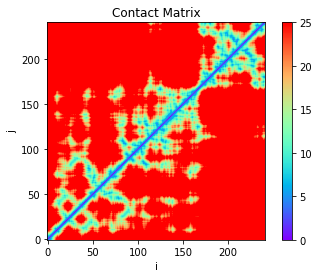

In [35]:
ct_mat = ct
# tools.hide_toggle()
print('Contact matrix shape:', ct_mat.shape)

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.title('Contact Matrix')
plt.imshow(ct_mat,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,25)
plt.colorbar(fraction=0.045, pad=0.05)